# Эксперименты

In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!pip install biopandas

     |████████████████████████████████| 266kB 7.1MB/s 


In [2]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import pdb
from biopandas.pdb import PandasPdb
ppdb = PandasPdb()

import os
import time
import numpy as np
from scipy.stats import pearsonr, kendalltau, spearmanr, zscore
from scipy import sparse 
from scipy.sparse import linalg
from tqdm import tqdm
import pickle

import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')

In [3]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [5]:
import collections

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = {}'.format(device))

cuda available
device = cuda


X – coordinates

A – adjacency matrices

y – cad-scores

**DATA format: {target_name}, {model_name}, {coordinates}, {adjacency_matrix}, {cad-score}**

# Лапласиан

Возьмем из маленького набора одну смоделированную структуру и проанализируем собственные числа лапласиана, полученного из матрицы смежности графа белка. 

In [0]:
DATA = np.load('../../data/data.npy', allow_pickle=True)

In [0]:
DATA_permuted = np.random.permutation(DATA)
DATA_permuted = DATA_permuted[DATA_permuted[:, 0] != 'T0863']
print(DATA_permuted[:, 0])

['T0859' 'T0864' 'T0859' 'T0860' 'T0866' 'T0866' 'T0859' 'T0859' 'T0859'
 'T0860' 'T0866' 'T0859' 'T0866' 'T0864' 'T0866' 'T0862' 'T0859' 'T0864'
 'T0859' 'T0862' 'T0859' 'T0859' 'T0859' 'T0864' 'T0866' 'T0864' 'T0859'
 'T0862' 'T0859' 'T0859' 'T0866' 'T0859' 'T0864' 'T0866' 'T0866' 'T0859'
 'T0860' 'T0860' 'T0860' 'T0859' 'T0859' 'T0860' 'T0864' 'T0866' 'T0862'
 'T0862' 'T0860' 'T0859' 'T0864' 'T0859' 'T0859' 'T0859' 'T0859' 'T0861'
 'T0859' 'T0860' 'T0861' 'T0861' 'T0859' 'T0864' 'T0859' 'T0859' 'T0860'
 'T0866' 'T0859' 'T0862' 'T0859' 'T0864' 'T0862' 'T0862' 'T0859' 'T0859'
 'T0866' 'T0859' 'T0865' 'T0859' 'T0859' 'T0859' 'T0862' 'T0864' 'T0860'
 'T0860' 'T0866' 'T0860' 'T0860' 'T0866' 'T0859' 'T0859' 'T0862' 'T0859'
 'T0862' 'T0859' 'T0859' 'T0859' 'T0859' 'T0864' 'T0865' 'T0864' 'T0859'
 'T0859' 'T0866' 'T0859' 'T0861' 'T0866' 'T0862' 'T0859' 'T0859' 'T0860'
 'T0864' 'T0859' 'T0859' 'T0862' 'T0859' 'T0859' 'T0862' 'T0859' 'T0860'
 'T0859' 'T0859' 'T0859' 'T0859' 'T0859' 'T0859' 'T

In [0]:
def laplacian(A):
    '''
    A - adjacency matrix
    d - degree matrix 
    Return graph Laplacian
    '''
    d = A.sum(axis=0)
    d += np.spacing(np.array(0, A.dtype)) # добавление epsilon
    d = 1 / np.sqrt(d)
    D = sparse.diags(d.squeeze(), 0)
    I = sparse.identity(d.size, dtype=A.dtype)
    L = I - D * A * D

    assert np.abs(L - L.T).mean() < 1e-9
    #assert type(L) is sparse.csr.csr_matrix
    return L.A

def lmax_L(L):
    """Compute largest Laplacian eigenvalue"""
    return linalg.eigsh(L, k=1, which='LM', return_eigenvectors=False)[0]

# L с волной
def rescale_L(L, lmax=2):
    """Rescale Laplacian eigenvalues to [-1,1]"""
    M, M = L.shape
    I = sparse.identity(M, format='csr', dtype=L.dtype)
    L /= lmax
    L *= 2
    L -= I
    return L.A

In [0]:
%%time
test_adj = DATA_permuted[2][3]
L = laplacian(test_adj)
l_max = lmax_L(L)
L_hat = rescale_L(L, l_max)

print('l_max = {}'.format(l_max))

l_max = 1.3719783230800977
CPU times: user 293 ms, sys: 37.4 ms, total: 330 ms
Wall time: 226 ms


Получившаяся матрица сильно разреженная. А максимальное собственное число близко к предположению в работе (~2). Ненулевых элементов ~0-2%:

In [0]:
not_zero = sum(sum(L_hat != 0))
total = len(L_hat)**2
print('Ненулевых элементов: {}\nВсего элементов в матрице: {}'.format(not_zero, total))
print(str(round(100 * not_zero / total, 3)) + '%')

Ненулевых элементов: 16446
Всего элементов в матрице: 976144
1.685%


# Главный эксперимент

In [0]:
# for colab
DRIVEPATH = '/content/drive/My Drive/CASP/'
CASPS = ['CASP9','CASP10','CASP11','CASP12']

Считаем в один словарь значения cad-score для смоделированных структур. Используются данные CASP9-12

In [0]:
def make_cad_dict():
    cad_scores_dict = dict()
    for casp in tqdm(CASPS):
        cad_path = DRIVEPATH + 'cad_results/' + casp + '/'
        targets = sorted(os.listdir(cad_path))
        for target in targets[:]:
            filepath = cad_path + target
            with open(filepath) as fp:
                line = fp.readline()
                while line:
                    list_temp = line.strip().split(' ')
                    target = list_temp[0].split('/')[-1][:-4]
                    model = list_temp[1].split('/')[-1]
                    cad = float(list_temp[4])
                    #cad_scores.append((target, model, cad))
                    cad_scores_dict.update({(target, model): cad})
                    line = fp.readline()
    return cad_scores_dict

In [8]:
cad_scores_dict = make_cad_dict()

100%|██████████| 4/4 [02:09<00:00, 32.32s/it]


## Модель

Модель на основе GCN, переделанная под регрессию.

In [0]:
class GraphConv(nn.Module):
    '''
    Graph Convolution Layer according to (T. Kipf and M. Welling, ICLR 2017)
    Additional tricks (power of adjacency matrix and weight self connections) as in the Graph U-Net paper
    '''
    def __init__(self,
                in_features,
                out_features,
                activation=None,
                adj_sq=False,
                scale_identity=False):
        super(GraphConv, self).__init__()
        self.fc = nn.Linear(in_features=in_features, out_features=out_features).double()
        self.adj_sq = adj_sq
        self.activation = activation
        self.scale_identity = scale_identity
            
    def laplacian_batch(self, A):
        batch=1
        N = A.shape[0]
        #batch, N = A.shape[:2]
        if self.adj_sq:
            A = torch.bmm(A, A)  # use A^2 to increase graph connectivity
        I = torch.eye(N).unsqueeze(0).double().to(device)
        if self.scale_identity:
            I = 2 * I  # increase weight of self connections
        A_hat = A + I
        D_hat = (torch.sum(A_hat, 1) + 1e-5) ** (-0.5)
        L = D_hat.view(batch, N, 1) * A_hat * D_hat.view(batch, 1, N)
        return L

    def forward(self, data):
        x, A = data
        a = torch.bmm(self.laplacian_batch(A), x)
        x = self.fc(a.double())
        if self.activation is not None:
            x = self.activation(x)
        return (x, A)
        
class GCN(nn.Module):
    '''
    Baseline Graph Convolutional Network with a stack of Graph Convolution Layers and global pooling over nodes.
    '''
    def __init__(self,
                 in_features,
                 out_features,
                 filters=[64,64,64],
                 n_hidden=0,
                 dropout=0.2,
                 adj_sq=False,
                 scale_identity=False):
        super(GCN, self).__init__()

        # Graph convolution layers
        self.gconv = nn.Sequential(*([GraphConv(in_features=in_features if layer == 0 else filters[layer - 1], 
                                                out_features=f, 
                                                activation=nn.ReLU(inplace=True),
                                                adj_sq=adj_sq,
                                                scale_identity=scale_identity) for layer, f in enumerate(filters)]))
        
        # Fully connected layers
        fc = []
        if dropout > 0:
            fc.append(nn.Dropout(p=dropout))
        if n_hidden > 0:
            fc.append(nn.Linear(filters[-1], n_hidden))
            if dropout > 0:
                fc.append(nn.Dropout(p=dropout))
            n_last = n_hidden
        else:
            n_last = filters[-1]
        fc.append(nn.Linear(n_last, out_features))       
        self.fc = nn.Sequential(*fc).double()
        
    def forward(self, data):
        # X, A = data
        x = self.gconv(data)[0]
        eigen = 1 # изначально еще анализировались собственные числа, перешли в отдельный ноутбук
        #eigen = np.linalg.svd(x[0].detach().numpy())[1]
        x = torch.max(x, dim=1)[0].squeeze()  # max pooling over nodes
        x = self.fc(x)
        return x, eigen
    

## Процесс обучения

In [0]:
SpectralQA = GCN(in_features=3,
            out_features=1,
            n_hidden=0,
            filters=[64,64,64],
            dropout=0.2,
            adj_sq=False,
            scale_identity=False).to(device)

In [53]:
del SpectralQA
torch.cuda.empty_cache()
!nvidia-smi

Sun Jun 21 08:37:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    60W / 149W |    785MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Т.к. не создавались отдельные датасеты, сделаем наборы train, test в виде путей до данных и перемешаем их

In [0]:
def make_train_set(competitions, num_targets):
    train_set = []
    unwanted = {'.DS_Store', 'adjacency', 'adjacency_old'}
    for casp in competitions:
        cad_path = DRIVEPATH + 'cad_results/' + casp + '/'
        targets = sorted(os.listdir(cad_path))
        for target in tqdm(targets[:num_targets]):
            target = target[:-11]
            models_path = DRIVEPATH + casp + '/models/' + target
            adj_path = DRIVEPATH + casp + '/models/' + target + '/adjacency/'

            # смотрим только те, к которым посчитаны матрицы смежности
            models = sorted(os.listdir(adj_path))
            #models = [model for model in models if model not in unwanted]
            for model in models:
                if model not in unwanted and cad_scores_dict[(target, model[:-8])] != 0.0:
                    train_set.append([target, model, casp])
    train_set = np.random.permutation(train_set)
    return train_set

Начнем с не очень большого набора данных

In [49]:
train_set = make_train_set(['CASP10'], 15)

100%|██████████| 15/15 [00:00<00:00, 364.68it/s]


In [50]:
test_set = make_train_set(['CASP11'], 3)

100%|██████████| 3/3 [00:00<00:00, 286.84it/s]


In [55]:
#print('\nInitialize model')
#print(SpectralQA)

wdecay = 1e-4
lr = 0.005
epochs = 10
batch_size = 1

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, SpectralQA.parameters()),
    lr=lr,
    weight_decay=wdecay,
    betas=(0.5, 0.999))
    
scheduler = lr_scheduler.MultiStepLR(optimizer, [20, 30], gamma=0.1)


def train():
    SpectralQA.train()
    scheduler.step()
    start = time.time()
    train_loss_ep = []
    n_samples = 0
    for_correlation = []
    #for batch_idx, data in enumerate(train_loader): 
    unwanted = {'.DS_Store', 'adjacency', 'adjacency_old'}
    for target, model, casp in train_set:
        adj_path = DRIVEPATH + casp + '/models/' + target + '/adjacency/'
        models_path = DRIVEPATH + casp + '/models/' + target

        temp = ppdb.read_pdb(models_path + '/'+ model[:-8])
        temp_model = ppdb.df['ATOM']
        protein_size = temp_model.shape[0]
        coords = temp_model[['x_coord', 'y_coord', 'z_coord']].values
        cad = cad_scores_dict[(target, model[:-8])]
        adjacency = np.zeros((protein_size, protein_size))
        with open(adj_path + model) as fp:
            line = fp.readline()
            while line:
                for t in line.strip().split(' '):
                    adjacency[int(t.split('_')[0])][int(t.split('_')[1])] = 1
                    adjacency[int(t.split('_')[1])][int(t.split('_')[0])] = 1
                line = fp.readline()

        coords = torch.tensor(coords).view(1,coords.shape[0], coords.shape[1]).to(device)
        data = (target, model[:-8], coords, torch.tensor(adjacency).to(device), torch.tensor(cad).to(device))

        optimizer.zero_grad()
        output, eigen = SpectralQA((data[2], data[3]))
        #print([data[0], output.item(), data[4].item()])
        for_correlation.append([data[0], output.item(), data[4].item()])
        loss = loss_fn(output.double(), data[4].double())
        loss.backward()
        optimizer.step()
        time_iter = time.time() - start
        train_loss_ep.append(loss.item())
        n_samples += len(output)

        if n_samples % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} (avg: {:.6f}) \tsec/iter: {:.4f} \tmin since start epoch: {:.4f}'.format(
                    epoch, n_samples, len(train_set),
                    100. * (n_samples + 1) / len(train_set), loss.item(), 
                    sum(train_loss_ep) / n_samples, time_iter / (n_samples + 1),
                    time_iter / 60 ))

    print('EPOCH TIME {} min'.format(time_iter / 60))
    
    '''
    for_correlation = np.array(for_correlation)
    targets_ep = list(set(for_correlation[:, 0]))
    pearson = np.mean(
        [pearsonr(np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,1], dtype='float64'), 
                  np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,2], dtype='float64')) 
         for i in range(len(targets_ep))])
    #pearsonr(), kendalltau(), spearmanr()
    #kendall = np.mean(
    #    [kendalltau(np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,1], dtype='float64'), 
    #              np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,2], dtype='float64')) 
    #     for i in range(len(targets_ep))])
    spearman = np.mean(
        [spearmanr(np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,1], dtype='float64'), 
                  np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,2], dtype='float64')) 
         for i in range(len(targets_ep))])
    '''
    
    return train_loss_ep, for_correlation 
    #pearson, kendall, spearman


def test():
    SpectralQA.eval()
    start = time.time()
    test_loss_ep = []
    correct, n_samples = 0, 0
    #for_correlation = []
    
    unwanted = {'.DS_Store', 'adjacency', 'adjacency_old'}
    print('STARTING TESTING')
    for target, model, casp in test_set:
        adj_path = DRIVEPATH + casp + '/models/' + target + '/adjacency/'
        models_path = DRIVEPATH + casp + '/models/' + target
    
        temp = ppdb.read_pdb(models_path + '/'+ model[:-8])
        temp_model = ppdb.df['ATOM']
        protein_size = temp_model.shape[0]
        coords = temp_model[['x_coord', 'y_coord', 'z_coord']].values
        cad = cad_scores_dict[(target, model[:-8])]
        adjacency = np.zeros((protein_size, protein_size))
        with open(adj_path + model) as fp:
            line = fp.readline()
            while line:
                for t in line.strip().split(' '):
                    adjacency[int(t.split('_')[0])][int(t.split('_')[1])] = 1
                    adjacency[int(t.split('_')[1])][int(t.split('_')[0])] = 1
                line = fp.readline()

        coords = torch.tensor(coords).view(1,coords.shape[0], coords.shape[1]).to(device)
        data = (target, model[:-8], coords, torch.tensor(adjacency).to(device), torch.tensor(cad).to(device))

        optimizer.zero_grad()
        #print(data[2:4])
        output, eigen = SpectralQA((data[2], data[3]))
        loss = loss_fn(output.double(), data[4].double())

        test_loss_ep.append(loss.item())
        n_samples += len(output)


    time_iter = time.time() - start
    print('Test set (epoch {}): Mean loss: {:.4f}\n'.format(epoch, np.mean(test_loss_ep)))
    
    return test_loss_ep

loss_fn = torch.nn.MSELoss()
mse_train_plot, mse_test_plot = [], []
correlation_data = []
pearson_train_plot, kendall_train_plot, spearman_train_plot = [], [], []
for epoch in range(epochs):
    train_loss, for_correlation = train()
    torch.save(SpectralQA.state_dict(), DRIVEPATH + 'model_train_smallset/ep_' + str(epoch) + '.model')
    with open(DRIVEPATH + 'correlation_data_smallset/corr_ep_' + str(epoch) + '.pickle', 'wb') as handle:
        pickle.dump(for_correlation, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(DRIVEPATH + 'correlation_data_smallset/trainloss_ep_' + str(epoch) + '.pickle', 'wb') as handle:
        pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    mse_train_plot.append(train_loss)
    correlation_data.append(for_correlation)
    #pearson_train_plot.append(pearson)
    #kendall_train_plot.append(kendall)
    #spearman_train_plot.append(spearman)

    test_loss = test()
    torch.save(SpectralQA.state_dict(), DRIVEPATH + 'model_train_smallset/ep_' + str(epoch) + 'aftertest.model')
    mse_test_plot.append(test_loss)
    with open(DRIVEPATH + 'correlation_data_smallset/testloss_ep_' + str(epoch) + '.pickle', 'wb') as handle:
        pickle.dump(test_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Epoch: 0 [1000/2250 (44%)]	Loss: 0.031749 (avg: 0.239240) 	sec/iter: 0.1941 	min since start epoch: 3.2385
Train Epoch: 0 [2000/2250 (89%)]	Loss: 0.000622 (avg: 0.121801) 	sec/iter: 0.1904 	min since start epoch: 6.3495
EPOCH TIME 6.713571314016978 min
STARTING TESTING
Test set (epoch 0): Mean loss: 0.0508

Train Epoch: 1 [1000/2250 (44%)]	Loss: 0.016999 (avg: 0.007328) 	sec/iter: 0.1938 	min since start epoch: 3.2326
Train Epoch: 1 [2000/2250 (89%)]	Loss: 0.001363 (avg: 0.004879) 	sec/iter: 0.1890 	min since start epoch: 6.3027
EPOCH TIME 6.664367179075877 min
STARTING TESTING
Test set (epoch 1): Mean loss: 0.0431

Train Epoch: 2 [1000/2250 (44%)]	Loss: 0.001405 (avg: 4.845559) 	sec/iter: 0.1932 	min since start epoch: 3.2234
Train Epoch: 2 [2000/2250 (89%)]	Loss: 0.000002 (avg: 2.427555) 	sec/iter: 0.1895 	min since start epoch: 6.3201
EPOCH TIME 6.687214438120524 min
STARTING TESTING
Test set (epoch 2): Mean loss: 0.0418

Train Epoch: 3 [1000/2250 (44%)]	Loss: 0.027215 (avg: 0

MSE ошибка на обучении

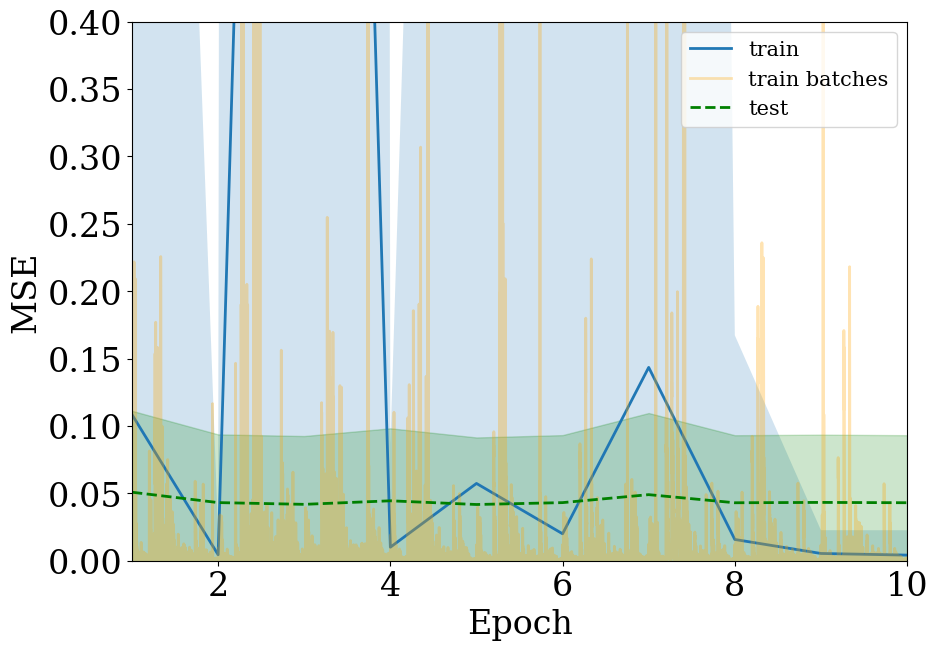

In [56]:
tr = np.array(mse_train_plot).flatten()

plt.figure(figsize=(10, 7))
axes = plt.gca()
axes.set_ylim([0,0.4])
axes.set_xlim([1,epochs])

plt.plot((np.arange(epochs)+1), np.mean(mse_train_plot,1), linestyle='-', label='train', alpha=2)
plt.fill_between((np.arange(epochs)+1), np.mean(mse_train_plot, 1)  + np.std(mse_train_plot, 1) , 
                 np.mean(mse_train_plot, 1) - np.std(mse_train_plot, 1), 
                 alpha = 0.2)


plt.plot((np.arange(len(tr))/2250)[2250:], tr[2250:], 
         linestyle='-', label='train batches', color='orange', alpha=0.3)

plt.plot((np.arange(epochs)+1), np.mean(mse_test_plot,1), linestyle='--', label='test', color='green') 
plt.fill_between((np.arange(epochs)+1), np.mean(mse_test_plot, 1)  + np.std(mse_test_plot, 1) , 
                 np.mean(mse_test_plot, 1) - np.std(mse_test_plot, 1), color='green',
                 alpha = 0.2)

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc="best", prop={'size': 15})

#plt.savefig(DRIVEPATH + '/pics/training_smallset.pdf')
plt.show()

Усредненная по нативным структурам корреляция

In [0]:
def get_correlations(correlation_data):
    pearson_train_plot = []
    spearman_train_plot = []
    pearson_total_train_plot = []
    spearman_total_train_plot = []
    for for_correlation in correlation_data:
        for_correlation = np.array(for_correlation)
        targets_ep = list(set(for_correlation[:, 0]))
        pearson_total = abs(pearsonr(np.array(for_correlation[:,1], dtype='float64'), 
                      np.array(for_correlation[:,2], dtype='float64'))[0])
        spearman_total = abs(spearmanr(np.array(for_correlation[:,1], dtype='float64'), 
                      np.array(for_correlation[:,2], dtype='float64'))[0])
        pearson_total_train_plot.append(pearson_total)
        spearman_total_train_plot.append(spearman_total)
        pearson = [abs(pearsonr(np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,1], dtype='float64'), 
                      np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,2], dtype='float64'))[0])
             for i in range(len(targets_ep))]
    
        spearman = [abs(spearmanr(np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,1], dtype='float64'), 
                      np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,2], dtype='float64'))[0])
             for i in range(len(targets_ep))]
    
        pearson_train_plot.append(pearson)
        spearman_train_plot.append(spearman)
    return pearson_train_plot, spearman_train_plot, pearson_total, spearman_total
        

In [7]:
pearson_train_plot, spearman_train_plot, pearson_total, spearman_total = get_correlations(correlation_data)

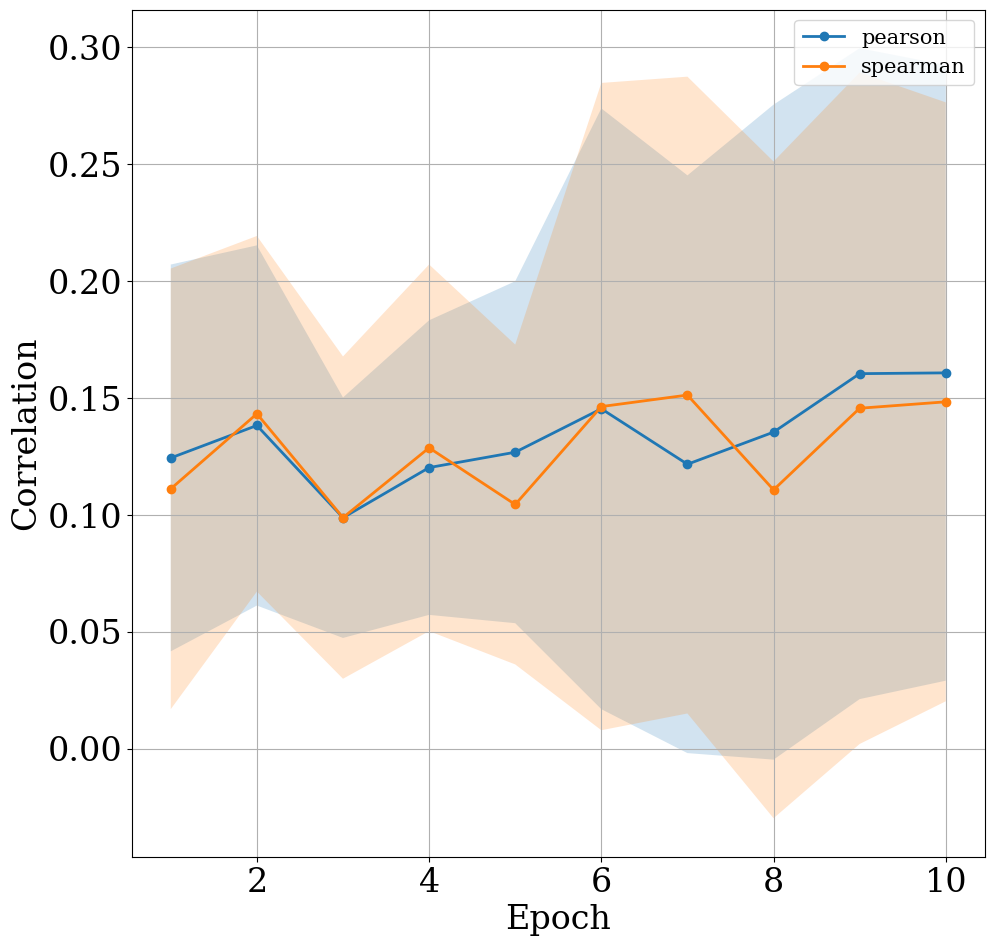

In [85]:
plt.figure(figsize=(11, 11))
plt.plot((np.arange(epochs)+1), np.mean(pearson_train_plot, 1), 
         marker='.', linestyle='-', label='pearson', alpha=1)
plt.fill_between((np.arange(epochs)+1), np.mean(pearson_train_plot, 1)  + np.std(pearson_train_plot, 1) , 
                 np.mean(pearson_train_plot, 1) - np.std(pearson_train_plot, 1), 
                 alpha = 0.2)
plt.plot((np.arange(epochs)+1), np.mean(spearman_train_plot, 1), 
         marker='.', linestyle='-', label='spearman', alpha=1)
plt.fill_between((np.arange(epochs)+1), np.mean(spearman_train_plot, 1)  + np.std(spearman_train_plot, 1) , 
                 np.mean(spearman_train_plot, 1) - np.std(spearman_train_plot, 1), 
                 alpha = 0.2)
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.grid()
plt.legend(loc="best", prop={'size': 15})

plt.savefig(DRIVEPATH + 'pics/training_correlations_smallsettt.pdf')
plt.show()

Глобальная корреляция

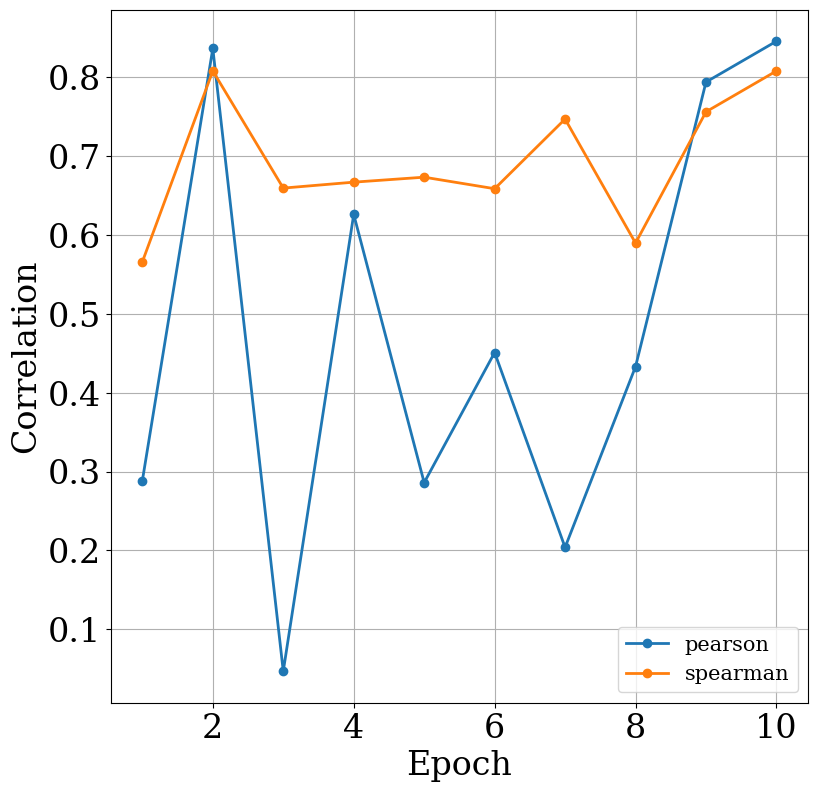

In [84]:
plt.figure(figsize=(9, 9))
plt.plot((np.arange(epochs)+1), pearson_total_train_plot, 
         marker='.', linestyle='-', label='pearson', alpha=1)
plt.plot((np.arange(epochs)+1), spearman_total_train_plot, 
         marker='.', linestyle='-', label='spearman', alpha=1)

plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.grid()
plt.legend(loc="best", prop={'size': 15})

plt.savefig(DRIVEPATH + 'pics/training_correlations_total_smallsettt.pdf')
plt.show()

In [83]:
print(np.mean(pearson_total_train_plot))
print(np.mean(spearman_total_train_plot))

0.4812171764331107
0.6934775722635746


In [74]:
def test_CASP12():
    SpectralQA.eval()
    start = time.time()
    test_loss_ep = []
    correct, n_samples = 0, 0
    for_correlation = []
    
    unwanted = {'.DS_Store', 'adjacency', 'adjacency_old'}
    print('STARTING TESTING')
    for target, model, casp in tqdm(test_set_CASP12):
        adj_path = DRIVEPATH + casp + '/models/' + target + '/adjacency/'
        models_path = DRIVEPATH + casp + '/models/' + target
    
        temp = ppdb.read_pdb(models_path + '/'+ model[:-8])
        temp_model = ppdb.df['ATOM']
        protein_size = temp_model.shape[0]
        coords = temp_model[['x_coord', 'y_coord', 'z_coord']].values
        cad = cad_scores_dict[(target, model[:-8])]
        adjacency = np.zeros((protein_size, protein_size))
        with open(adj_path + model) as fp:
            line = fp.readline()
            while line:
                for t in line.strip().split(' '):
                    adjacency[int(t.split('_')[0])][int(t.split('_')[1])] = 1
                    adjacency[int(t.split('_')[1])][int(t.split('_')[0])] = 1
                line = fp.readline()

        coords = torch.tensor(coords).view(1,coords.shape[0], coords.shape[1]).to(device)
        data = (target, model[:-8], coords, torch.tensor(adjacency).to(device), torch.tensor(cad).to(device))

        optimizer.zero_grad()
        #print(data[2:4])
        output, eigen = SpectralQA((data[2], data[3]))
        #print(output)
        for_correlation.append([data[0], output.item(), data[4].item()])
        loss = loss_fn(output.double(), data[4].double())

        test_loss_ep.append(loss.item())
        n_samples += len(output)


    time_iter = time.time() - start
    #print('Test set (epoch {}): Mean loss: {:.4f}\n'.format(epoch, np.mean(test_loss_ep)))
    
    return test_loss_ep, for_correlation

loss_casp12, correlation_casp12 = test_CASP12()

  0%|          | 0/450 [00:00<?, ?it/s]

STARTING TESTING


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 450/450 [00:55<00:00,  8.08it/s]


In [75]:
for_correlation = np.array(correlation_casp12)
targets_ep = list(set(for_correlation[:, 0]))
pearson_total = abs(pearsonr(np.array(for_correlation[:,1], dtype='float64'), 
                  np.array(for_correlation[:,2], dtype='float64'))[0])
spearman_total = abs(spearmanr(np.array(for_correlation[:,1], dtype='float64'), 
                  np.array(for_correlation[:,2], dtype='float64'))[0])

print(pearson_total, spearman_total)

pearson = [abs(pearsonr(np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,1], dtype='float64'), 
                  np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,2], dtype='float64'))[0])
         for i in range(len(targets_ep))]

spearman = [abs(spearmanr(np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,1], dtype='float64'), 
                  np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,2], dtype='float64'))[0])
         for i in range(len(targets_ep))]

print(pearson, spearman)

0.05764573103160084 0.0651377259849742
[0.06307369493718652, 0.20821682894405952, 0.10766291245339894] [0.04938944631643418, 0.20913993119854238, 0.25545783209044615]


------------

# С тестированием на CASP12

Повторим то же самое, но с тестированием на CASP12

In [5]:
test_set = make_train_set(['CASP12'], 3)

In [97]:
wdecay = 1e-4
lr = 0.005
epochs = 10
batch_size = 1

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, SpectralQA.parameters()),
    lr=lr,
    weight_decay=wdecay,
    betas=(0.5, 0.999))
    
scheduler = lr_scheduler.MultiStepLR(optimizer, [20, 30], gamma=0.1)


loss_fn = torch.nn.MSELoss()
mse_train_plot, mse_test_plot = [], []
correlation_data = []
pearson_train_plot, kendall_train_plot, spearman_train_plot = [], [], []
for epoch in range(epochs):
    train_loss, for_correlation = train()
    torch.save(SpectralQA.state_dict(), DRIVEPATH + 'model_train_smallset/small_settt_ep_' + str(epoch) + '.model')
    with open(DRIVEPATH + 'correlation_data_smallset/small_settt_corr_ep_' + str(epoch) + '.pickle', 'wb') as handle:
        pickle.dump(for_correlation, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(DRIVEPATH + 'correlation_data_smallset/small_settt_trainloss_ep_' + str(epoch) + '.pickle', 'wb') as handle:
        pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    mse_train_plot.append(train_loss)
    correlation_data.append(for_correlation)

    test_loss, for_correlation_test = test()
    torch.save(SpectralQA.state_dict(), DRIVEPATH + 'model_train_smallset/small_settt_ep_' + str(epoch) + 'aftertest.model')
    mse_test_plot.append(test_loss)
    with open(DRIVEPATH + 'correlation_data_smallset/small_settt_testloss_ep_' + str(epoch) + '.pickle', 'wb') as handle:
        pickle.dump(test_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Epoch: 0 [1000/2250 (44%)]	Loss: 0.127075 (avg: 0.270801) 	sec/iter: 0.1932 	min since start epoch: 3.2236
Train Epoch: 0 [2000/2250 (89%)]	Loss: 0.001300 (avg: 0.137539) 	sec/iter: 0.1896 	min since start epoch: 6.3239
EPOCH TIME 6.697652391592661 min
STARTING TESTING
Test set (epoch 0): Mean loss: 0.0445

Train Epoch: 1 [1000/2250 (44%)]	Loss: 0.021242 (avg: 0.007646) 	sec/iter: 0.1947 	min since start epoch: 3.2478
Train Epoch: 1 [2000/2250 (89%)]	Loss: 0.001507 (avg: 0.005264) 	sec/iter: 0.1899 	min since start epoch: 6.3326
EPOCH TIME 6.706608283519745 min
STARTING TESTING
Test set (epoch 1): Mean loss: 0.0442

Train Epoch: 2 [1000/2250 (44%)]	Loss: 0.016516 (avg: 0.010814) 	sec/iter: 0.1951 	min since start epoch: 3.2549
Train Epoch: 2 [2000/2250 (89%)]	Loss: 0.001638 (avg: 0.006478) 	sec/iter: 0.1900 	min since start epoch: 6.3372
EPOCH TIME 6.703696393966675 min
STARTING TESTING
Test set (epoch 2): Mean loss: 0.0431

Train Epoch: 3 [1000/2250 (44%)]	Loss: 0.026400 (avg: 0

In [103]:
for_correlation = np.array(for_correlation_test)
targets_ep = list(set(for_correlation[:, 0]))
pearson_total = abs(pearsonr(np.array(for_correlation[:,1], dtype='float64'), 
                  np.array(for_correlation[:,2], dtype='float64'))[0])
spearman_total = abs(spearmanr(np.array(for_correlation[:,1], dtype='float64'), 
                  np.array(for_correlation[:,2], dtype='float64'))[0])

print(pearson_total, spearman_total)

pearson = [abs(pearsonr(np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,1], dtype='float64'), 
                  np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,2], dtype='float64'))[0])
         for i in range(len(targets_ep))]

spearman = [abs(spearmanr(np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,1], dtype='float64'), 
                  np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,2], dtype='float64'))[0])
         for i in range(len(targets_ep))]

print(pearson, spearman)

0.29037219643217566 0.22702446194389916
[0.02922748073686796, 0.2964527807817639, 0.32057361192571543] [0.02585131540190383, 0.3468301822839353, 0.19670478686337114]


Довольно низкие значения корреляции. Стоит смотреть на тестирование на более ранних эпохах

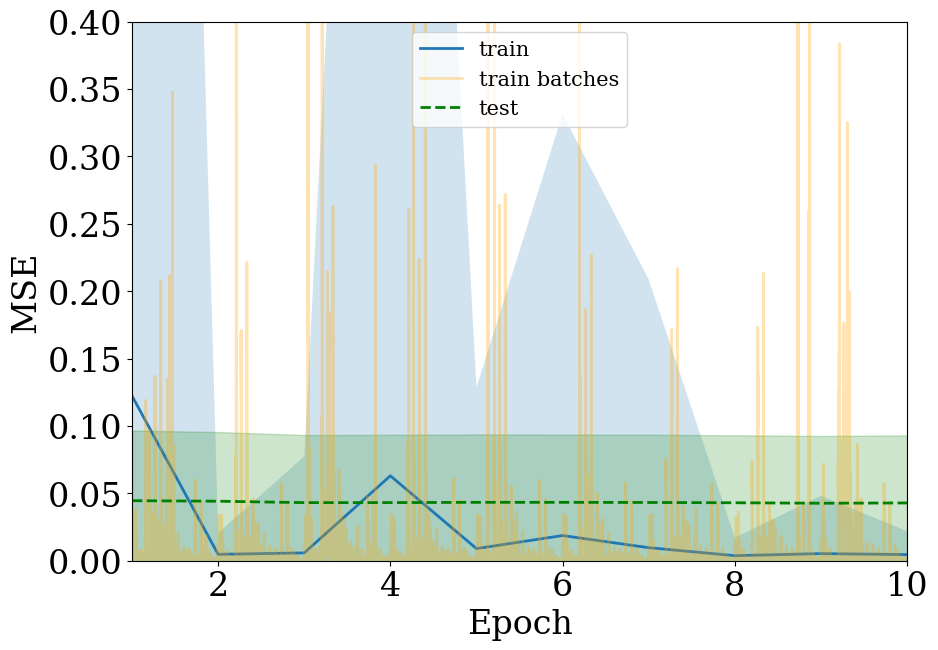

In [98]:
tr = np.array(mse_train_plot).flatten()

plt.figure(figsize=(10, 7))
axes = plt.gca()
axes.set_ylim([0,0.4])
axes.set_xlim([1,epochs])

plt.plot((np.arange(epochs)+1), np.mean(mse_train_plot,1), linestyle='-', label='train', alpha=2)
plt.fill_between((np.arange(epochs)+1), np.mean(mse_train_plot, 1)  + np.std(mse_train_plot, 1) , 
                 np.mean(mse_train_plot, 1) - np.std(mse_train_plot, 1), 
                 alpha = 0.2)


plt.plot((np.arange(len(tr))/2250)[2250:], tr[2250:], 
         linestyle='-', label='train batches', color='orange', alpha=0.3)

plt.plot((np.arange(epochs)+1), np.mean(mse_test_plot,1), linestyle='--', label='test', color='green') 
plt.fill_between((np.arange(epochs)+1), np.mean(mse_test_plot, 1)  + np.std(mse_test_plot, 1) , 
                 np.mean(mse_test_plot, 1) - np.std(mse_test_plot, 1), color='green',
                 alpha = 0.2)

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc="best", prop={'size': 15})

#plt.savefig(DRIVEPATH + '/pics/training_smallset.pdf')
plt.show()

Усредненная по нативным структурам корреляция

In [0]:
pearson_train_plot, spearman_train_plot, pearson_total, spearman_total = get_correlations(correlation_data)

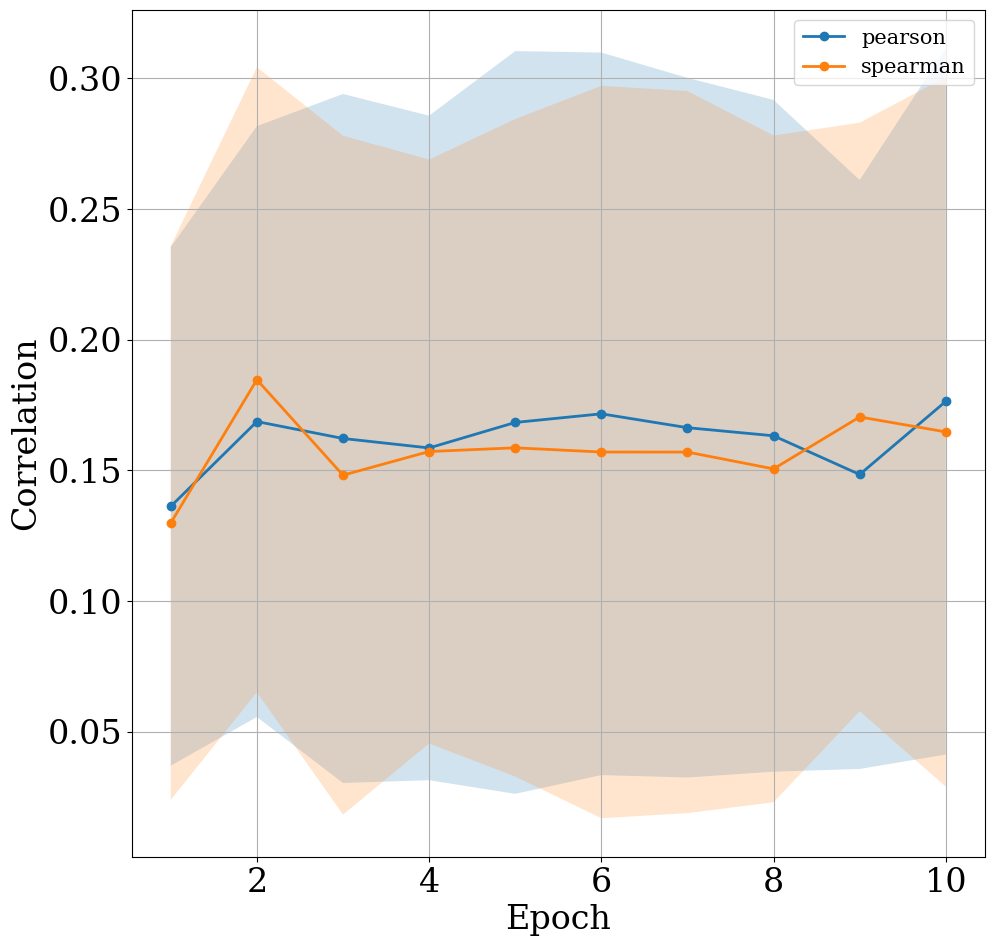

In [101]:
plt.figure(figsize=(11, 11))
plt.plot((np.arange(epochs)+1), np.mean(pearson_train_plot, 1), 
         marker='.', linestyle='-', label='pearson', alpha=1)
plt.fill_between((np.arange(epochs)+1), np.mean(pearson_train_plot, 1)  + np.std(pearson_train_plot, 1) , 
                 np.mean(pearson_train_plot, 1) - np.std(pearson_train_plot, 1), 
                 alpha = 0.2)
plt.plot((np.arange(epochs)+1), np.mean(spearman_train_plot, 1), 
         marker='.', linestyle='-', label='spearman', alpha=1)
plt.fill_between((np.arange(epochs)+1), np.mean(spearman_train_plot, 1)  + np.std(spearman_train_plot, 1) , 
                 np.mean(spearman_train_plot, 1) - np.std(spearman_train_plot, 1), 
                 alpha = 0.2)
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.grid()
plt.legend(loc="best", prop={'size': 15})

#plt.savefig(DRIVEPATH + 'pics/training_correlations_smallset.pdf')
plt.show()

Глобальная корреляция

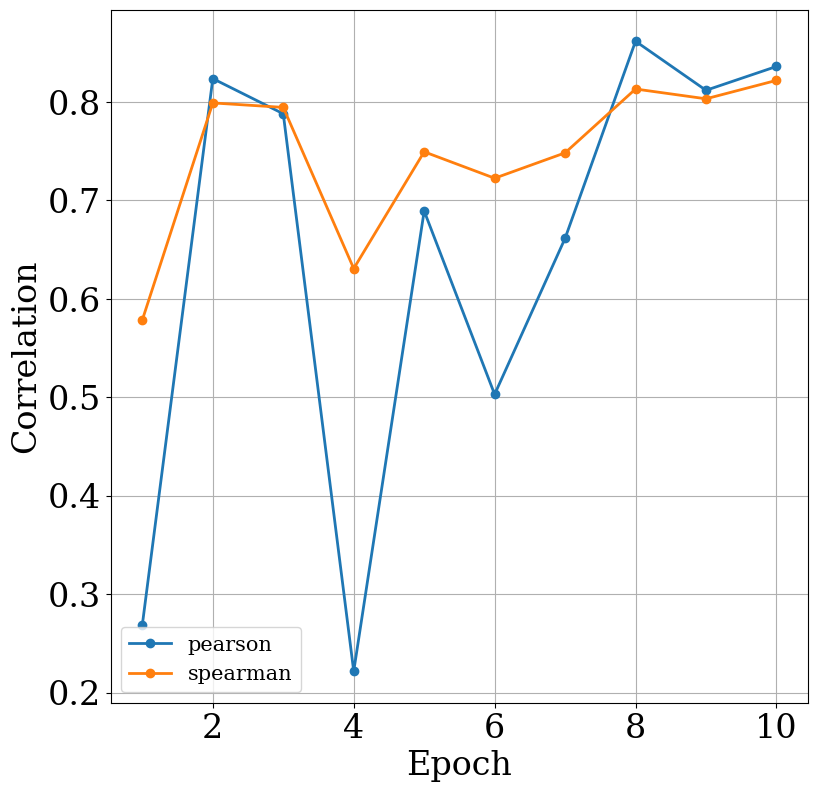

In [102]:
plt.figure(figsize=(9, 9))
plt.plot((np.arange(epochs)+1), pearson_total_train_plot, 
         marker='.', linestyle='-', label='pearson', alpha=1)
plt.plot((np.arange(epochs)+1), spearman_total_train_plot, 
         marker='.', linestyle='-', label='spearman', alpha=1)

plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.grid()
plt.legend(loc="best", prop={'size': 15})

plt.savefig(DRIVEPATH + 'pics/training_total_correlations_smallset.pdf')
plt.show()

In [107]:
print(round(np.mean(pearson_total_train_plot),3))
print(round(np.mean(spearman_total_train_plot), 3))

0.647
0.746


In [93]:
#loss_casp12, correlation_casp12 = test_CASP12()

  0%|          | 0/450 [00:00<?, ?it/s]

STARTING TESTING


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 450/450 [00:55<00:00,  8.07it/s]


## 90 targets train + 15 taregts validation

Проделаем то же самое на большом датасете с >20000 структур на обучении

In [4]:
train_set = make_train_set(['CASP10', 'CASP11'], 45)
test_set = make_train_set(['CASP12'], 15)

Обучалась на колабе. По истечении сеанса загружаем последние сохраненные веса и продолжаем обучение.

In [12]:
SpectralQA = GCN(in_features=3,
            out_features=1,
            n_hidden=0,
            filters=[64,64,64],
            dropout=0.2,
            adj_sq=False,
            scale_identity=False).to(device)

weights_path = DRIVEPATH + 'model_train/ep_6aftertest.model'
SpectralQA.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [13]:
wdecay = 1e-4
lr = 0.005
epochs = 10
batch_size = 1

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, SpectralQA.parameters()),
    lr=lr,
    weight_decay=wdecay,
    betas=(0.5, 0.999))
    
scheduler = lr_scheduler.MultiStepLR(optimizer, [20, 30], gamma=0.1)


loss_fn = torch.nn.MSELoss()
mse_train_plot, mse_test_plot = [], []
correlation_data = []
pearson_train_plot, kendall_train_plot, spearman_train_plot = [], [], []
for epoch in range(epochs):
    train_loss, for_correlation = train()
    torch.save(SpectralQA.state_dict(), DRIVEPATH + 'model_train/ep_' + str(epoch) + '.model')
    with open(DRIVEPATH + 'correlation_data/corr_ep_' + str(epoch) + '.pickle', 'wb') as handle:
        pickle.dump(for_correlation, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(DRIVEPATH + 'correlation_data/trainloss_ep_' + str(epoch) + '.pickle', 'wb') as handle:
        pickle.dump(train_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
    mse_train_plot.append(train_loss)
    correlation_data.append(for_correlation)

    test_loss = test()
    torch.save(SpectralQA.state_dict(), DRIVEPATH + 'model_train/ep_' + str(epoch) + 'aftertest.model')
    mse_test_plot.append(test_loss)
    with open(DRIVEPATH + 'correlation_data/testloss_ep_' + str(epoch) + '.pickle', 'wb') as handle:
        pickle.dump(test_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)
     

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train Epoch: 7 [1000/20436 (5%)]	Loss: 0.010879 (avg: 0.031071) 	sec/iter: 0.7149 	min since start epoch: 11.9265
Train Epoch: 7 [2000/20436 (10%)]	Loss: 0.010608 (avg: 0.028823) 	sec/iter: 0.7150 	min since start epoch: 23.8451
Train Epoch: 7 [3000/20436 (15%)]	Loss: 0.034152 (avg: 0.027777) 	sec/iter: 0.7305 	min since start epoch: 36.5354
Train Epoch: 7 [4000/20436 (20%)]	Loss: 0.009690 (avg: 0.028086) 	sec/iter: 0.7385 	min since start epoch: 49.2470
Train Epoch: 7 [5000/20436 (24%)]	Loss: 0.004259 (avg: 0.027747) 	sec/iter: 0.7339 	min since start epoch: 61.1674
Train Epoch: 7 [6000/20436 (29%)]	Loss: 0.043453 (avg: 0.027332) 	sec/iter: 0.7342 	min since start epoch: 73.4327
Train Epoch: 7 [7000/20436 (34%)]	Loss: 0.020803 (avg: 0.028774) 	sec/iter: 0.7357 	min since start epoch: 85.8443
Train Epoch: 7 [8000/20436 (39%)]	Loss: 0.001979 (avg: 0.028250) 	sec/iter: 0.7323 	min since start epoch: 97.6495
Train Epoch: 7 [9000/20436 (44%)]	Loss: 0.001064 (avg: 0.031252) 	sec/iter: 0.732

In [0]:
mse_train_plot, mse_test_plot = [], []
for epoch in range(epochs):
    with open(DRIVEPATH + 'correlation_data/trainloss_ep_' + str(epoch) + '.pickle', 'rb') as handle:
        mse_train_plot.append(pickle.load(handle))

for epoch in range(epochs):
    with open(DRIVEPATH + 'correlation_data/testloss_ep_' + str(epoch) + '.pickle', 'rb') as handle:
        mse_test_plot.append(pickle.load(handle))

In [0]:
correlation_data = []
for epoch in range(epochs):
    with open(DRIVEPATH + 'correlation_data/corr_ep_' + str(epoch) + '.pickle', 'rb') as handle:
        correlation_data.append(pickle.load(handle))

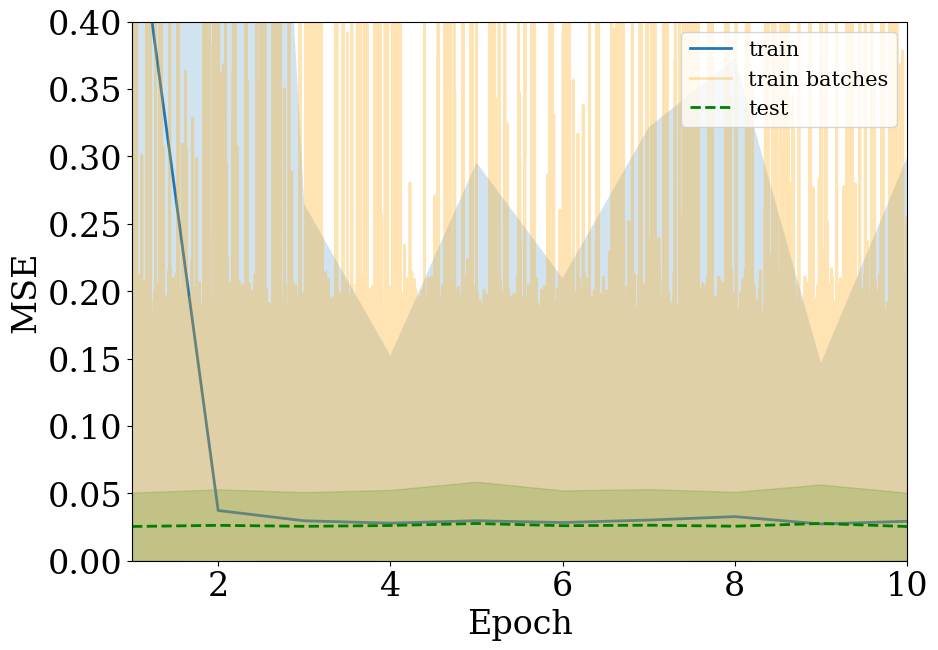

In [32]:
tr = np.array(mse_train_plot).flatten()

plt.figure(figsize=(10, 7))
axes = plt.gca()
axes.set_ylim([0,0.4])
axes.set_xlim([1,epochs])

plt.plot((np.arange(epochs)+1), np.mean(mse_train_plot,1), linestyle='-', label='train', alpha=2)
plt.fill_between((np.arange(epochs)+1), np.mean(mse_train_plot, 1)  + np.std(mse_train_plot, 1) , 
                 np.mean(mse_train_plot, 1) - np.std(mse_train_plot, 1), 
                 alpha = 0.2)


plt.plot((np.arange(len(tr))/20436)[20436:], tr[20436:], 
         linestyle='-', label='train batches', color='orange', alpha=0.3)

plt.plot((np.arange(epochs)+1), np.mean(mse_test_plot,1), linestyle='--', label='test', color='green') 
plt.fill_between((np.arange(epochs)+1), np.mean(mse_test_plot, 1)  + np.std(mse_test_plot, 1) , 
                 np.mean(mse_test_plot, 1) - np.std(mse_test_plot, 1), color='green',
                 alpha = 0.2)

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc="best", prop={'size': 15})

plt.savefig(DRIVEPATH + '/pics/training.pdf')
plt.show()

In [74]:
pearsonr(np.array(np.array(correlation_data[0])[:,1], dtype='float64'), 
          np.array(np.array(correlation_data[0])[:,2], dtype='float64'))

(0.37256784277089244, 1.0510794202082598e-45)

Удалим для анализа корреляции значения, где истинный cad-score равен 0.

In [26]:
print(len(correlation_data[0]))
sum_zeros = 0
for i, correletion in enumerate(correlation_data):
    for j, data in enumerate(correletion):
        if data[2] == 0.0:
            sum_zeros += 1
            del correlation_data[i][j]

print(len(correlation_data[0]))
print(sum_zeros)

20436
19688
7445


In [8]:
pearson_train_plot, spearman_train_plot, pearson_total, spearman_total = get_correlations(correlation_data)

In [0]:
pearson_train_plot = []
spearman_train_plot = []
pearson_total_train_plot = []
spearman_total_train_plot = []
for for_correlation in correlation_data:
    for_correlation = np.array(for_correlation)
    targets_ep = list(set(for_correlation[:, 0]))
    pearson_total = abs(pearsonr(np.array(for_correlation[:,1], dtype='float64'), 
                  np.array(for_correlation[:,2], dtype='float64'))[0])
    spearman_total = abs(spearmanr(np.array(for_correlation[:,1], dtype='float64'), 
                  np.array(for_correlation[:,2], dtype='float64'))[0])
    pearson_total_train_plot.append(pearson_total)
    spearman_total_train_plot.append(spearman_total)
    pearson = [abs(pearsonr(np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,1], dtype='float64'), 
                  np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,2], dtype='float64'))[0])
         for i in range(len(targets_ep))]

    spearman = [abs(spearmanr(np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,1], dtype='float64'), 
                  np.array(for_correlation[for_correlation[:,0]==targets_ep[i]][:,2], dtype='float64'))[0])
         for i in range(len(targets_ep))]
    
    pearson_train_plot.append(pearson)
    spearman_train_plot.append(spearman)

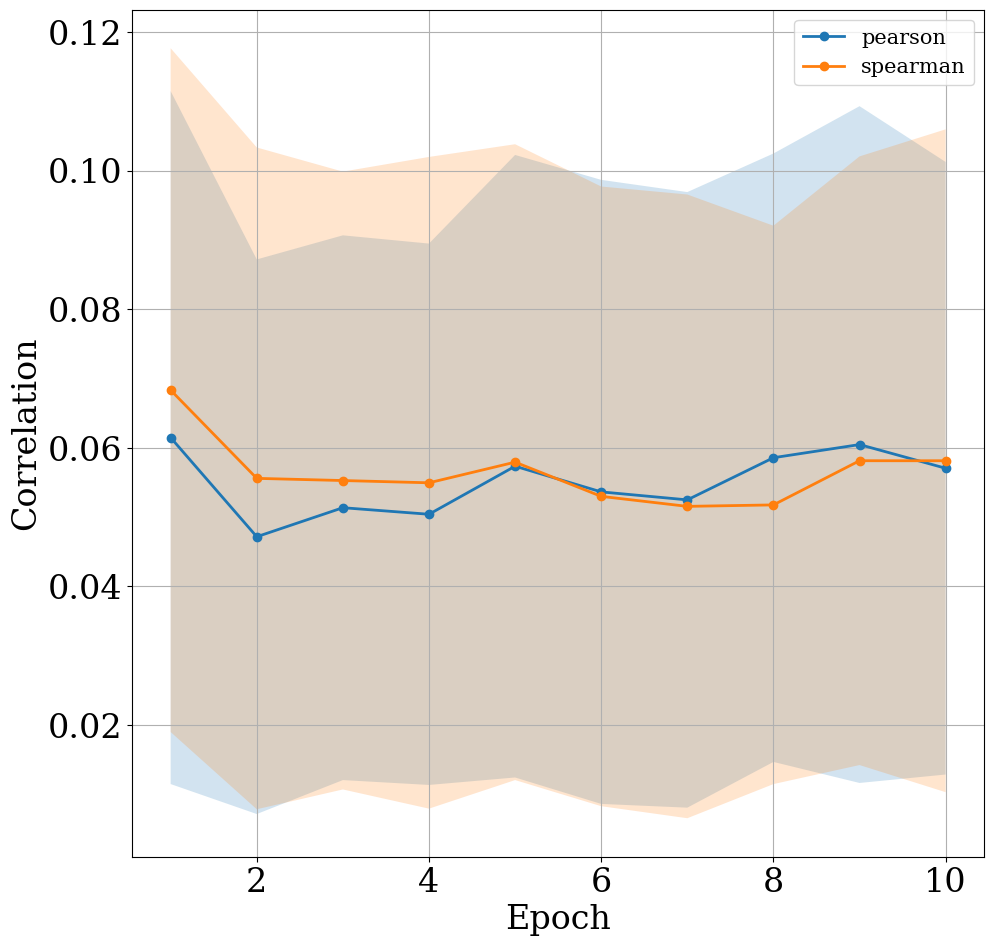

In [28]:
plt.figure(figsize=(11, 11))
plt.plot((np.arange(epochs)+1), np.mean(pearson_train_plot, 1), 
         marker='.', linestyle='-', label='pearson', alpha=1)
plt.fill_between((np.arange(epochs)+1), np.mean(pearson_train_plot, 1)  + np.std(pearson_train_plot, 1) , 
                 np.mean(pearson_train_plot, 1) - np.std(pearson_train_plot, 1), 
                 alpha = 0.2)
plt.plot((np.arange(epochs)+1), np.mean(spearman_train_plot, 1), 
         marker='.', linestyle='-', label='spearman', alpha=1)
plt.fill_between((np.arange(epochs)+1), np.mean(spearman_train_plot, 1)  + np.std(spearman_train_plot, 1) , 
                 np.mean(spearman_train_plot, 1) - np.std(spearman_train_plot, 1), 
                 alpha = 0.2)
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.grid()
plt.legend(loc="best", prop={'size': 15})

plt.savefig(DRIVEPATH + 'pics/training_correlations.pdf')
plt.show()

In [94]:
max(spearman_total_train_plot)

0.7903945888122751

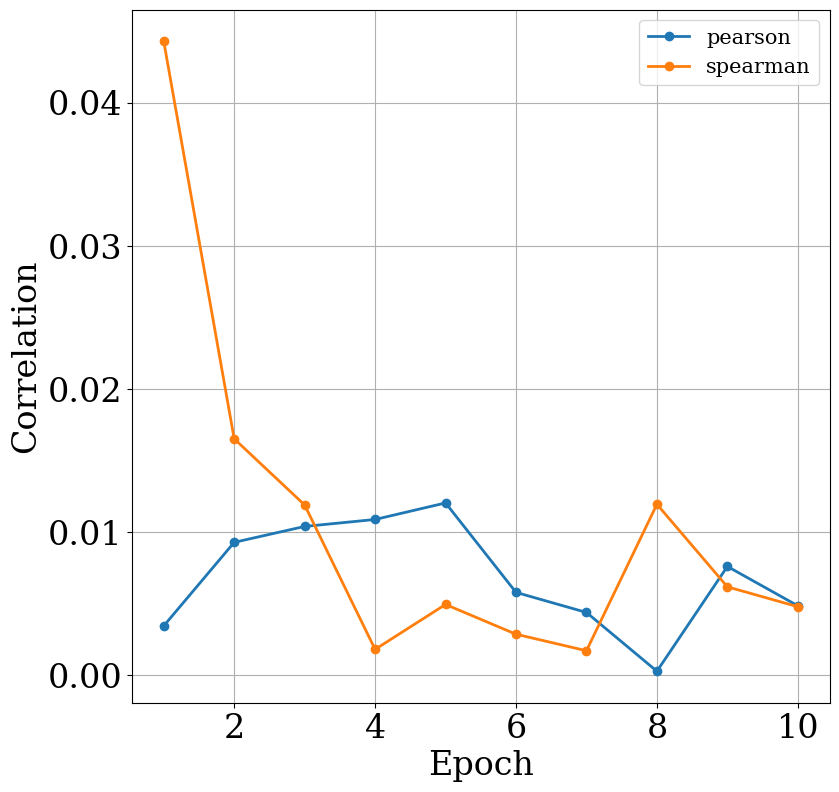

In [29]:
plt.figure(figsize=(9, 9))
plt.plot((np.arange(epochs)+1), pearson_total_train_plot, 
         marker='.', linestyle='-', label='pearson', alpha=1)
plt.plot((np.arange(epochs)+1), spearman_total_train_plot, 
         marker='.', linestyle='-', label='spearman', alpha=1)

plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.grid()
plt.legend(loc="best", prop={'size': 15})

plt.savefig(DRIVEPATH + 'pics/training_correlations.pdf')
plt.show()

Переобучение